In [1]:
import os, sys
sys.path.append("src/")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
from types import SimpleNamespace
import math, json
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from einops import rearrange
from PIL import Image, ImageDraw
import torch

from musubi_tuner.dataset.image_video_dataset import resize_image_to_bucket
from musubi_tuner.networks import lora_framepack
from musubi_tuner.frame_pack.clip_vision import hf_clip_vision_encode
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan import encode_prompt_conds, vae_encode, vae_decode
from musubi_tuner.frame_pack.hunyuan_video_packed import load_packed_model, attn_cache
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan
from musubi_tuner.frame_pack.utils import crop_or_pad_yield_mask
from musubi_tuner.wan_generate_video import merge_lora_weights

device = torch.device('cuda')
lt.monkey_patch()

2025-07-22 17:13:54.187647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753172034.206204  107601 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753172034.211970  107601 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-22 17:13:54.241012: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment 

Trying to import sageattention
Successfully imported sageattention


In [2]:
dit_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors"
vae_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/VAE/hunyuan-video-t2v-720p-vae.pt"
text_encoder1_path = "/shared/video/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors"
text_encoder2_path = "/shared/video/ComfyUI/models/text_encoders/clip_l.safetensors"
image_encoder_path = "/shared/video/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors"
lora_path = "/data/whisperer/related/framepackbase/musubi-tuner/outputs/training/s2vnexus_posecontrol_lora/lora_test1-000004.safetensors"

model = load_packed_model(device, dit_path, 'sageattn', device)
model.to(device)
model.eval().requires_grad_(False)

if lora_path != '':
    merge_lora_weights(lora_framepack, model, 
        SimpleNamespace(
            lora_weight = [lora_path], lora_multiplier = [1.0], 
            include_patterns=None, exclude_patterns=None, 
            lycoris=None, save_merged_model=False), 
    device, None)

vae = load_vae(vae_path, 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(SimpleNamespace(text_encoder1=text_encoder1_path), False, device)
tokenizer2, text_encoder2 = load_text_encoder2(SimpleNamespace(text_encoder2=text_encoder2_path))
feature_extractor, image_encoder = load_image_encoders(SimpleNamespace(image_encoder=image_encoder_path))

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors, device=cuda
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors, info=<All keys matched successfully>
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from /data/whisperer/related/framepackbase/musubi-tuner/outputs/training/s2vnexus_posecontrol_lora/lora_test1-000004.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:create LoRA for U-Net/DiT: 440 modules.
INFO:musubi_tuner.networks.lora:weights are merged
INFO:musubi_tuner.wan_generate_video:LoRA weights loaded
INFO:musubi_tuner.hunyuan_model.vae:Loading 3D VAE mod

In [3]:
def get_text_preproc(prompt, text_encoder1, text_encoder2, tokenizer1, tokenizer2, device=torch.device('cuda')):
    with torch.autocast(device_type=device.type, dtype=text_encoder1.dtype), torch.no_grad():
        llama_vec, clip_l_pooler, llama_strtokens = encode_prompt_conds(
            prompt, text_encoder1, text_encoder2, tokenizer1, tokenizer2, custom_system_prompt=None, return_tokendict=True
        )
        llama_vec = llama_vec.to(device, dtype=torch.bfloat16)
        clip_l_pooler = clip_l_pooler.to(device, dtype=torch.bfloat16)
        llama_vec, llama_attention_mask = crop_or_pad_yield_mask(llama_vec, length=512)

    llama_vec_n = torch.zeros_like(llama_vec).to(device, dtype=torch.bfloat16)
    clip_l_pooler_n  = torch.zeros_like(clip_l_pooler).to(device, dtype=torch.bfloat16)
    llama_vec_n, llama_attention_mask_n = crop_or_pad_yield_mask(llama_vec_n, length=512)
    return {
        "prompt_embeds" : llama_vec,
        "prompt_embeds_mask" : llama_attention_mask,
        "prompt_poolers" : clip_l_pooler,
        "negative_prompt_embeds" : llama_vec_n,
        "negative_prompt_embeds_mask" : llama_attention_mask_n,
        "negative_prompt_poolers" : clip_l_pooler_n,
    }, llama_strtokens

def getres(orig_width, orig_height, target_area=480*480, div_factor=16):
    aspect_ratio = orig_width / orig_height

    new_height = math.sqrt(target_area / aspect_ratio)
    new_width = target_area / new_height

    new_width = int(round(new_width / div_factor) * div_factor)
    new_height = int(round(new_height / div_factor) * div_factor)

    return new_width, new_height

def preproc_image(image_path, width=None, height=None):
    image_pil = Image.open(image_path).convert("RGB")
    image_np = np.array(image_pil)
    if width is not None and height is not None:
        image_np = resize_image_to_bucket(image_np, (width, height))
    image_tensor = (torch.from_numpy(image_np).float() / 127.5 - 1.0).permute(2,0,1)[None, :, None]
    return image_tensor, image_np

def preproc_mask(mask_path, width, height):
    if mask_path == '':
        image_pil = Image.new("L", (width // 8, height // 8), 255)
    else:
        image_pil = Image.open(mask_path).convert("L")
    image_np = np.array(image_pil)
    if width is not None and height is not None:
        image_np = resize_image_to_bucket(image_np,  (width // 8, height // 8))
    image_tensor = (torch.from_numpy(image_np).float() / 255.0)[None, None, None, :, :]
    return image_tensor, image_np

def prepare_image_inputs(image_path,feature_extractor, image_encoder, width=None, height=None, 
                         target_index=1, device=torch.device('cuda'), dtype=torch.bfloat16):
    img_tensor, img_np = preproc_image(image_path, width, height)
    with torch.no_grad():
        image_encoder_output = hf_clip_vision_encode(img_np, feature_extractor, image_encoder)
    image_encoder_last_hidden_state = image_encoder_output.last_hidden_state.to(device, dtype=dtype)

    latent_indices = torch.tensor([target_index], dtype=torch.int64)  # 1x1 latent index for target image
    return {
        "image_embeddings" : image_encoder_last_hidden_state,
        "latent_indices" : latent_indices,
    } , img_np

def prepare_control_inputs(control_image_paths, control_image_mask_paths, width=None, height=None,
                           control_indices=[0,10]):
    control_latents, control_nps = [], []
    for i, (control_image_path, control_mask_path) in enumerate(zip(control_image_paths, control_image_mask_paths)):
        c_img_tensor, c_img_np = preproc_image(control_image_path, width, height)
        c_img_latent = vae_encode(c_img_tensor, vae).cpu()
        c_mask_image, c_mask_np = preproc_mask(control_mask_path, width, height)
        c_img_latent = c_img_latent * c_mask_image
        control_latents.append(c_img_latent)
        control_nps.append(np.concatenate([c_img_np, resize_image_to_bucket(c_mask_np, (width, height))[..., None]], -1))
    clean_latents = torch.cat(control_latents, dim=2)  # (1, 16, num_control_images, H//8, W//8)
    clean_latent_indices = torch.tensor([control_indices], dtype=torch.int64)

    return {
        "clean_latents" : clean_latents, 
        "clean_latent_indices" : clean_latent_indices,
        "clean_latents_2x" : None, 
        "clean_latent_2x_indices" : None,
        "clean_latents_4x" : None, 
        "clean_latent_4x_indices" : None,
    } , control_nps

In [4]:
# prompt = Path('/data/whisperer/outputs/20250716_141340/[PANEL-2]/prompt.txt').read_text()
# image_path = "/data/whisperer/datasets/storyviz/ViStoryBench/ViStoryBench/10/image/Mr. Qin/00.jpg"
# control_image_paths = ['/data/whisperer/outputs/20250716_141340/[PANEL-2]/skeleton_img.png']

in_folder = Path("/data/whisperer/outputs/20250717_154000/[PANEL-1]")
prompt = (in_folder / "prompt.txt").read_text()
# image_path = str(in_folder / "chara_img.png")

# image_path = "/data/whisperer/datasets/storyviz/ViStoryBench/ViStoryBench/07/image/Lin Shangrong/00.jpg"
image_path = "/data/whisperer/datasets/storyviz/ViStoryBench/ViStoryBench/13/image/Tian Qi/00.jpg"
control_image_paths = [str(in_folder / "skeleton_img.png")]

og_width, og_height = Image.open(control_image_paths[0]).size
width, height = getres(og_width, og_height, target_area=960*960, div_factor=16)

control_image_mask_paths = ["", ""]
target_index = [9]
control_indices = [10]

[252, 462, 413, 984]
1664 560
[416, 256, 680, 544]


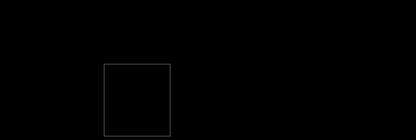

In [5]:
layout = json.loads((in_folder.parent / "pose_layout.json").read_bytes())
bbox = layout[in_folder.name]['body'][0][:4]

new_bbox = [
    max(0, min(round(bbox[0] / 1000 * width), width)) // 8 * 8,
    max(0, min(round(bbox[1] / 1000 * height), height))// 8 * 8,
    max(0, min(round(bbox[2] / 1000 * width), width)) // 8 * 8,
    max(0, min(round(bbox[3] / 1000 * height), height)) // 8 * 8,
]

print(bbox)
print(width, height)
print(new_bbox)

debug_bboximg = Image.new("RGB", (width, height), "BLACK")
debug_draw = ImageDraw.Draw(debug_bboximg)
debug_draw.rectangle(new_bbox)
debug_bboximg.resize((debug_bboximg.size[0] // 4, debug_bboximg.size[1] // 4))

# with torch.no_grad():
#     latent_indices = torch.tensor([9], dtype=torch.int64)
#     rope_freqs = model.rope(
#         frame_indices=latent_indices, height=height, width=width, device=device
#     )
#     print(rope_freqs.shape)
#     rope_freqs = rope_freqs[:,:,:,new_bbox[1]:new_bbox[3], new_bbox[0]:new_bbox[2]]
#     print(rope_freqs.shape)
#     tmp = rope_freqs[0,:,0,:,:].mean(axis=0).to(dtype=torch.float32).cpu().numpy()

#     norm = plt.Normalize(vmin=tmp.min(), vmax=tmp.max()) 
#     attention_image = Image.fromarray((plt.cm.viridis(norm(tmp))[:, :, :3] * 255).astype(np.uint8))

# attention_image

  0%|          | 0/25 [00:00<?, ?it/s]

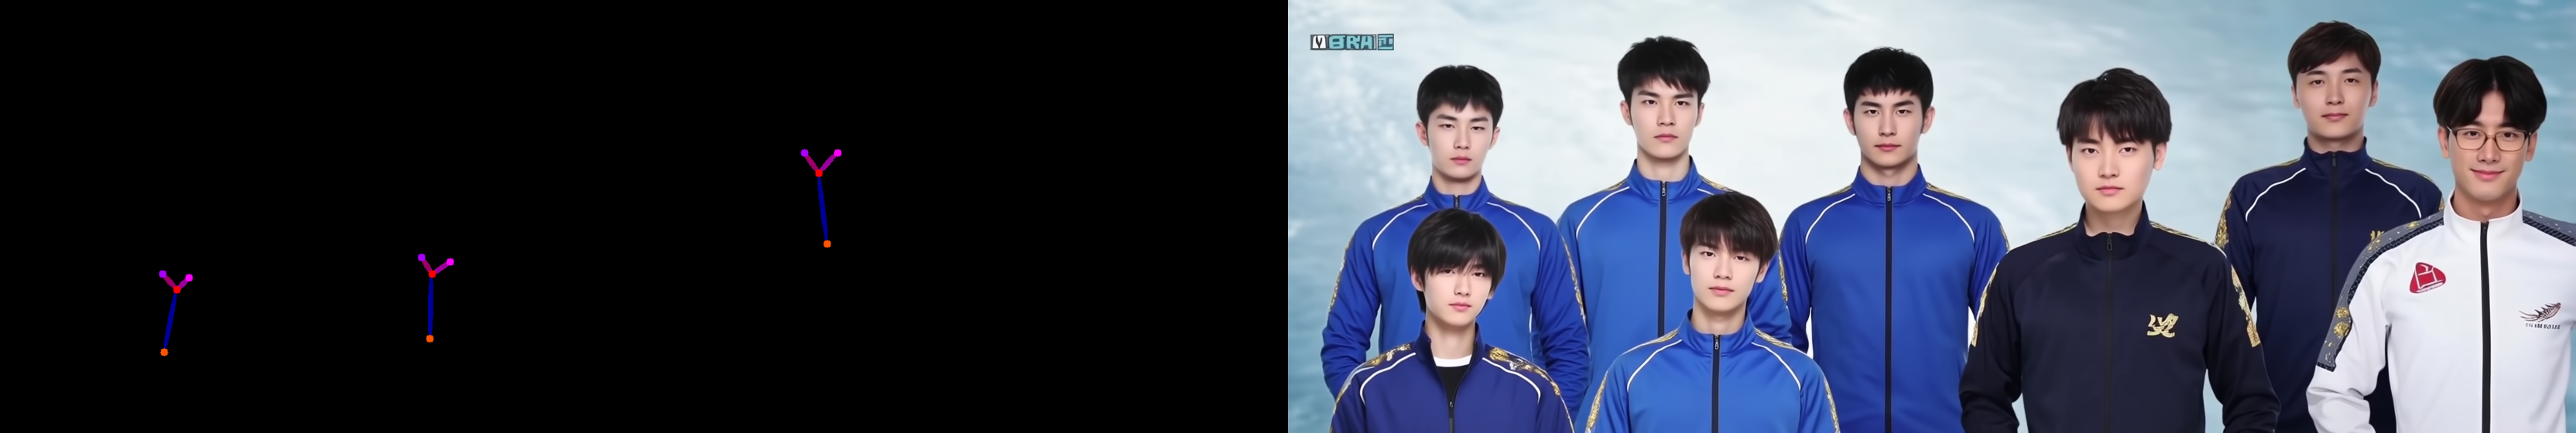

In [6]:
## Text Preprocessing

text_kwargs, llama_strtokens = get_text_preproc(prompt, text_encoder1, text_encoder2, tokenizer1, tokenizer2, device=device)

## Image Preprocessing
image_kwargs, img_np = prepare_image_inputs(
    image_path, feature_extractor, image_encoder, width=width, height=height, 
    target_index=target_index, device=device, dtype=torch.bfloat16)

control_kwargs, control_nps = prepare_control_inputs(
    control_image_paths, control_image_mask_paths, width=width, height=height, 
    control_indices=control_indices)

num_inference_steps=25
seed = 42
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

attn_cache.clear()
results = sample_hunyuan(
    transformer=model, sampler='unipc', width=width, height=height, frames=1,
    real_guidance_scale=1.0, distilled_guidance_scale=10.0, guidance_rescale=0.0, shift=None,
    num_inference_steps=num_inference_steps,
    generator=generator, device=device, dtype=torch.bfloat16,
    cache_results=False, 
    cache_layers = ['transformer_blocks.2', 'transformer_blocks.8', 'transformer_blocks.14'], 
    clean_latent_bbox=None,
    **text_kwargs, 
    **image_kwargs,
    **control_kwargs
)
history_pixels = torch.cat([
    vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() for i in range(results.shape[2])
], dim=2)
result_img = (torch.clamp(((history_pixels[0,:,0,:,:]+1.0)/2.0).permute(1,2,0).cpu(), 0.0, 1.0) * 255.).numpy().astype(np.uint8)
result_img = np.concatenate([result_img, np.ones(result_img.shape[:2] + (1, ))*255], axis=-1).astype(np.uint8)

Image.fromarray(np.concatenate(control_nps + [result_img], axis=1))

torch.Size([1, 2531, 26, 34])


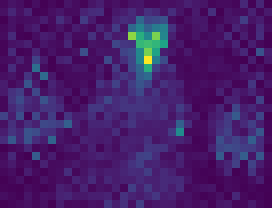

In [27]:
input_str = 'Empress' 

def get_text_inds_from_dict(input_str, llama_strtokens):
    start_inds = [i for i, x in llama_strtokens.items() if input_str.startswith(x)]
    end_inds = [i for i, x in llama_strtokens.items() if input_str.endswith(x)]

    if len(start_inds) == 0 or len(end_inds) == 0:
        print("Error")
        return []
    else:
        if len(start_inds) > 1 or len(end_inds) > 1:
            return list(range(start_inds[0], end_inds[-1]+1))
        else:
            return list(range(start_inds[0], end_inds[0]+1))
        
def get_attn_map(attn_cache, attn_inds, block_id=f'transformer_blocks.2', 
                 token_type = 'text',
                 height=960, width=960, token_C=2,
                 embed_size = 729,
                 t_0=0, t_1=25):
    timesteps = sorted(list(attn_cache[list(attn_cache.keys())[0]].keys()), reverse=False)
    token_H, token_W = height // 16, width // 16
    hidden_size = token_H * token_W * token_C
    
    attention_probs = sum(attn_cache[block_id][timesteps[t]] for t in range(t_0, t_1))
    attention_map = attention_probs[:,:,:hidden_size,:]
    attention_map = rearrange(attention_map, 'B A (C H W) D -> B A C H W D', H=token_H, W=token_W)
    attention_map = attention_map[:,:,-1,:,:,:].sum(1).squeeze(1).permute(0,3,1,2) #B, D, H, W
    if token_type == 'text':
        attn_inds = [hidden_size+embed_size+x for x in attn_inds]
    elif token_type == 'image':
        attn_inds = list(range((token_H*token_W*attn_inds[0]), (token_H*token_W*(attn_inds[0]+1))))
    else:
        attn_inds = attn_inds
    print(attention_map.shape)
    attention_data = attention_map[0,attn_inds,:,:].mean(axis=0).to(dtype=torch.float32).cpu().numpy()

    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=attention_data.min(), vmax=attention_data.max()) # Normalize data to [0,1] range
    colored_data = cmap(norm(attention_data))[:, :, :3] * 255 # Get RGB values and scale to 0-255
    colored_data_uint8 = colored_data.astype(np.uint8)
    attention_image = Image.fromarray(colored_data_uint8)
    return attention_image

attn_inds = get_text_inds_from_dict(input_str, llama_strtokens)
attn_images = get_attn_map(attn_cache, attn_inds, block_id=f'transformer_blocks.14', token_type = 'text',
                           height=height, width=width, token_C=len(control_indices + target_index))
attn_images.resize((width//2, height//2), Image.Resampling.NEAREST)